# Test on real world data

In [3]:
from helper import *
import torch
import torchvision
import torchvision.transforms as transforms
import os

In [4]:
from torchvision.io import read_image, ImageReadMode

In [5]:
dir = "data_pngs"
subjects = {}
for subject in os.listdir(dir):
    for pic in os.listdir(os.path.join(dir, subject)):
        f = os.path.join(dir, subject, pic)
        img = read_image(f, ImageReadMode.GRAY)
        img = torchvision.transforms.ConvertImageDtype(torch.float64)(img)
        img = torch.flatten(img.squeeze().T)
        if subjects.get(subject) == None:
            subjects[subject] = img
        else:
            subjects[subject] = torch.column_stack((subjects[subject], img))

## New functions

In [6]:
def thres(inputs, t, hard=True, old=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))
    else:
        if old:
            out = inputs * (torch.abs(inputs) > t)
        else:
            # out = torch.sign(inputs) * torch.max(\
            #                                     torch.abs(inputs) - torch.nan_to_num(torch.div(torch.pow(t, 6), torch.pow(torch.abs(inputs), 5))) \
            #                                     , torch.zeros(inputs.shape))
            # out = torch.sign(inputs) * torch.max(torch.abs(inputs) \
            #                                     - torch.div(t, torch.exp(3 * torch.div(torch.abs(inputs) - t, t))) \
            #                                     , torch.zeros(inputs.shape))
            # out = inputs * torch.max(1 - torch.div(torch.pow(t, 2), torch.pow(inputs, 2)), torch.zeros(inputs.shape))
            # out = torch.div(1,  1 + torch.exp(-100 * (torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))))) \
            #         + torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape)) \
            #         - t
            # mu = 1.0005 * t
            # out = inputs * (torch.abs(inputs) >= mu) \
            #         + torch.sign(inputs) * (mu/(mu-t))*(torch.abs(inputs) - t) * (mu > torch.abs(inputs)) * (torch.abs(inputs) >= t)
            gamma, beta = 0.95, 1
            out = inputs * (torch.abs(inputs) > torch.sqrt(gamma * beta * t**2)) * (beta <= gamma) \
                    + torch.sign(inputs) * torch.min(beta/(beta - gamma) * torch.max(torch.abs(inputs) - (t * gamma), torch.zeros(inputs.shape)), torch.abs(inputs)) * (beta > gamma)
    return out

In [7]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, d1, d2):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(1/(2 * np.power(d1 * d2, 1/4))))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

In [8]:
def train_nn(net, r, lr, weight_decay, nepochs, dataset):
    torch.autograd.set_detect_anomaly(False)
    params_bftrain = [x.clone().detach().numpy() for x in list(net.parameters())]
    optimizer = Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    l0_norm_of_S_Shat = []
    for epoch in range(nepochs):
        for i in range(len(dataset)):
            L0, S0, M0 = dataset[i]
            optimizer.zero_grad()
            L_hat, S_hat = net(M0, r)
            print(net.err[-1])
            loss = torch.pow(torch.linalg.norm(L0 - L_hat), 2)/ torch.pow(torch.linalg.norm(L0), 2) \
                    + torch.pow(torch.linalg.norm(S0 - S_hat), 2)/ torch.pow(torch.linalg.norm(S0), 2) \
                    #+ torch.pow(torch.linalg.norm(M0 - L_hat - S_hat), 2)
            # loss = torch.linalg.norm(L0 - L_hat)/ torch.linalg.norm(L0) \
            #         + torch.linalg.norm(S0 - S_hat)/ torch.linalg.norm(S0)
            loss.backward()
            optimizer.step()
            l0_norm_of_S_Shat.append(torch.count_nonzero(S0 - S_hat))
            print(list(net.parameters()))
            print(net.gamma.grad, net.beta.grad)
            print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(loss.item()))
    print('Finished Training')
    params_aftrain = [x.clone().detach().numpy() for x in list(net.parameters())]
    return net, params_bftrain, params_aftrain, l0_norm_of_S_Shat

In [9]:
def get_net_outputs(net_trained, net_bftrain, r, dataset):
    out_bftrain = []
    out_hat = []
    for i in range(len(dataset)):
        M_true = dataset[i]
        L_bftrain, S_bftrain = net_bftrain(M_true, r)
        print(net_bftrain.err[-1])
        out_bftrain.append((L_bftrain.detach().numpy(), S_bftrain.detach().numpy()))
        L_hat, S_hat = net_trained(M_true, r)
        print(net_trained.err[-1])
        out_hat.append((L_hat.detach().numpy(), S_hat.detach().numpy()))
    out_bftrain = np.asarray(out_bftrain)
    out_hat = np.asarray(out_hat)
    return out_bftrain, out_hat

In [42]:
def plot_true_vs_est_matrices(L_hat, L_true, S_hat, S_true):
    combined = np.concatenate((L_hat, L_true, S_hat, S_true))
    #fig, [ax1, ax2] = plt.subplots(1,2)
    plt.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    #ax1.set_title("L_hat")
    #plt.colorbar(im1, ax=ax1)
    plt.show()
    plt.imshow(L_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    #ax2.set_title("L_true")
    #plt.colorbar(im2, ax=ax2)
    plt.show()
    #fig, [ax3, ax4] = plt.subplots(1,2)
    plt.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    #ax3.set_title("S_hat")
    #plt.colorbar(im3, ax=ax3)
    plt.show()
    plt.imshow(S_true, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
    #ax4.set_title("S_true")
    #plt.colorbar(im4, ax=ax4)
    plt.show()

In [11]:
def AccAltProj(M0, r, tol, gamma, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    beta = 1/(2 * np.power(m * n, 1/4))
    beta_init = 4 * beta
    zeta = beta_init * torch.linalg.norm(M0, 2)
    S = thres(M0, zeta)#, False)
    U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
    ## NOTE: torch.linalg.svd(M) returns U, S, V such that M=USV not USV.T
    U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
    L = U @ torch.diag(Sigma) @ V.t()
    zeta = beta * Sigma[0]
    S = thres(M0 - L, zeta)#, False)
    ## Initial loss
    err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
    loss.append(err)
    for t in range(max_iter):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sigma, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sigma[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sigma[r] + torch.pow(gamma, t + 1) * Sigma[0])
        S = thres(M0 - L, zeta)#, False)
        ## Compute error
        err = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        loss.append(err)
        if err < tol:
            return loss, L, S
    return loss, L, S



## returns: loss, L, S
def IRCUR(M0, r, tol, gamma, con, max_iter):
    m, n = M0.shape
    norm_of_M0 = torch.linalg.norm(M0)
    ## Keep track of loss
    loss = []
    ## Initialization
    siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
    zeta = torch.max(torch.abs(M0))
    C, pinv_U, R = torch.zeros(M0.shape), torch.zeros([M0.shape[1], M0.shape[0]]), torch.zeros(M0.shape)
    for t in range(max_iter):
        ## resample rows and columns
        rows, cols = resample(m, n, siz_row, siz_col)
        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        ## compute submatrices of L from previous iteration
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        ## update S using submatrices of L
        S_rows = thres(M0_rows - L_rows, zeta)
        S_cols = thres(M0_cols - L_cols, zeta)
        ## update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,Vh = torch.linalg.svd(MU, full_matrices=False)
        ## calculate Moore-Penrose inverse of Sigma
        pinv_U = Vh.t()[:,:r] @ torch.diag(1./Sigma[:r]) @ U[:, :r].t()
        ## update zeta
        zeta = gamma * zeta
        ## update loss
        err = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        loss.append(err)
        if err < tol:
            L = C @ pinv_U @ R
            S = thres(M0 - L, zeta)
            return loss, L, S
    L = C @ pinv_U @ R
    S = thres(M0 - L, zeta)
    return loss, L, S

## Training

In [12]:
r = 1
max_iter = 50

In [13]:
print("original beta =", 1/(2 * np.power(243 * 320 * 11, 1/4)))

original beta = 0.01644117189829903


In [46]:
list(net.parameters())

[Parameter containing:
 tensor(0.6978, requires_grad=True),
 Parameter containing:
 tensor(0.0160, dtype=torch.float64, requires_grad=True)]

In [14]:
train = [subjects[x] for x in ['subject01', 'subject02', 'subject03', 'subject04', 'subject05', 'subject06', 'subject07']]
test = [subjects[x] for x in ['subject08', 'subject09', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15']]
train_est = []
for i, M_true in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))
    print(loss[-1])

tensor(9.2365e-07, dtype=torch.float64)
tensor(8.6727e-07, dtype=torch.float64)
tensor(9.2767e-07, dtype=torch.float64)
tensor(8.5915e-07, dtype=torch.float64)
tensor(6.5829e-07, dtype=torch.float64)
tensor(7.9093e-07, dtype=torch.float64)
tensor(9.8465e-07, dtype=torch.float64)


In [19]:
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter, 243 * 320, 11), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

9.52695628098885e-09
[Parameter containing:
tensor(0.6998, requires_grad=True), Parameter containing:
tensor(0.0162, dtype=torch.float64, requires_grad=True)]
tensor(0.2419) tensor(0.8808, dtype=torch.float64)
Epoch 1/8 at cost=0.04526102583078117
1.7590503882071652e-08
[Parameter containing:
tensor(0.6997, requires_grad=True), Parameter containing:
tensor(0.0162, dtype=torch.float64, requires_grad=True)]
tensor(-0.1041) tensor(-0.6281, dtype=torch.float64)
Epoch 1/8 at cost=0.029667217433512975
1.510317998074923e-08
[Parameter containing:
tensor(0.6999, requires_grad=True), Parameter containing:
tensor(0.0163, dtype=torch.float64, requires_grad=True)]
tensor(-1.5429) tensor(-6.1846, dtype=torch.float64)
Epoch 1/8 at cost=0.03471284353892602
1.9881599995418287e-08
[Parameter containing:
tensor(0.6999, requires_grad=True), Parameter containing:
tensor(0.0164, dtype=torch.float64, requires_grad=True)]
tensor(0.3676) tensor(1.1523, dtype=torch.float64)
Epoch 1/8 at cost=0.3626624611036295

## on train data

In [20]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter, 243 * 320, 11), r, train)

9.52695628098885e-09
8.54606499664123e-09
1.8903088175409683e-08
1.337959084831671e-08
1.494700693429234e-08
1.2764559317639915e-08
1.9849328084523343e-08
1.5033433947221257e-08
1.371990676499046e-08
1.2665657648764366e-08
2.211343921398061e-08
1.4443407269146232e-08
9.312456057335848e-09
8.156141241804278e-09


In [ ]:
out_hat[0][0].shape

(77760, 11)

In [50]:
out_accaltproj = []
for i, M_true in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    print(loss[-1])
    out_accaltproj.append((L0, S0, M_true))

tensor(8.7872e-07, dtype=torch.float64)
tensor(8.9039e-07, dtype=torch.float64)
tensor(8.7484e-07, dtype=torch.float64)
tensor(7.3572e-07, dtype=torch.float64)
tensor(8.1900e-07, dtype=torch.float64)
tensor(8.5820e-07, dtype=torch.float64)
tensor(7.7940e-07, dtype=torch.float64)


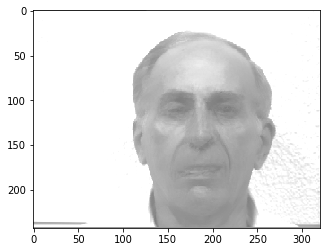

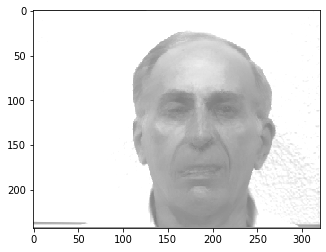

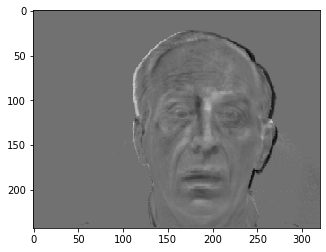

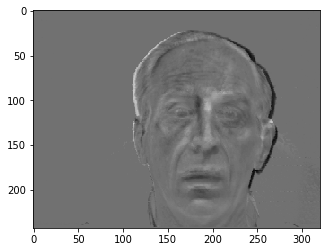

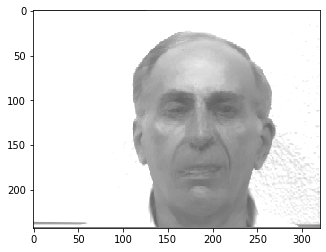

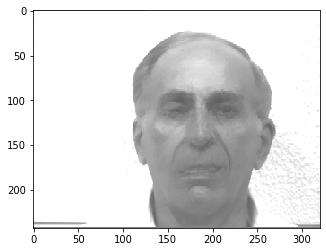

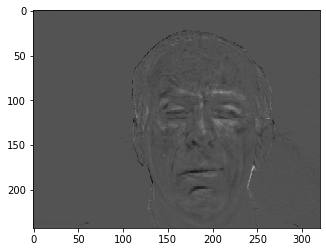

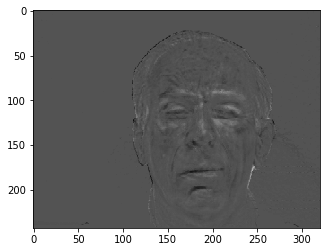

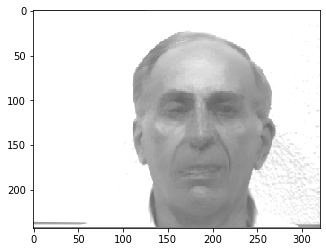

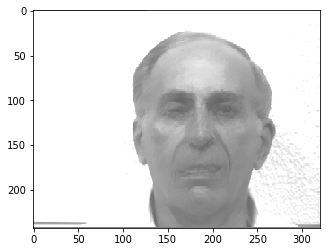

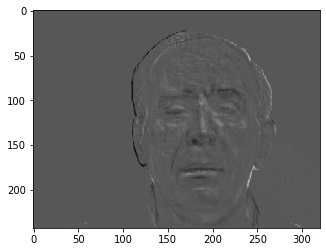

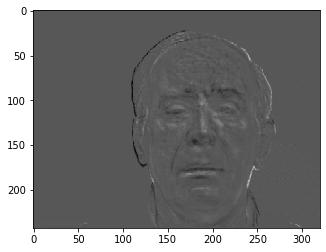

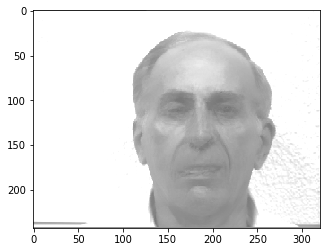

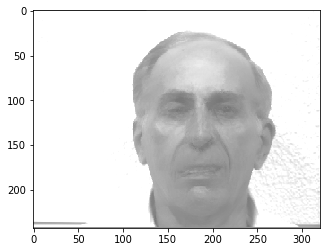

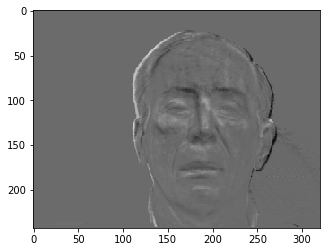

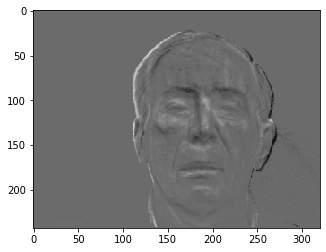

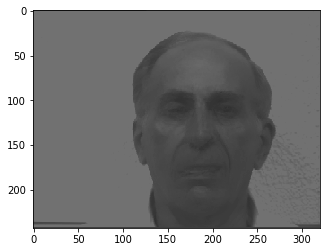

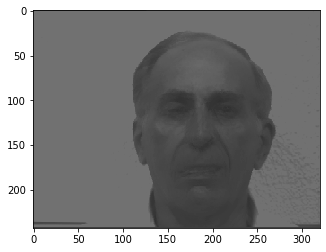

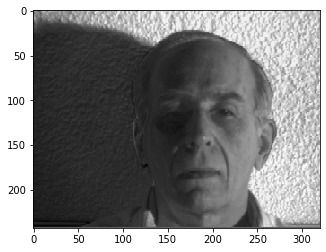

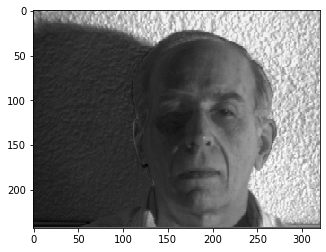

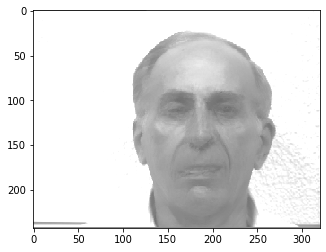

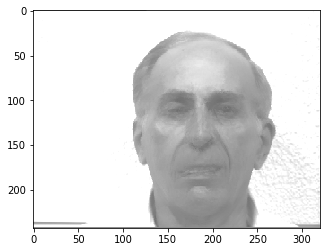

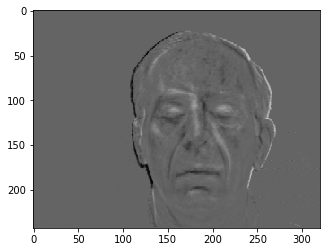

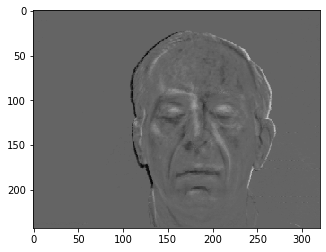

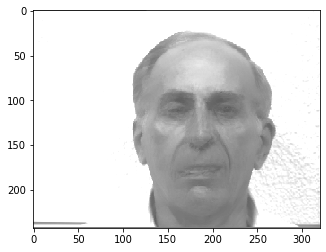

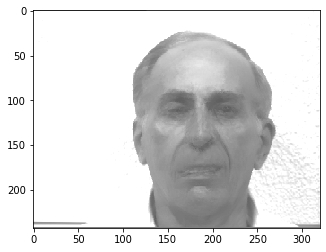

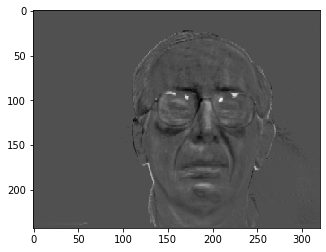

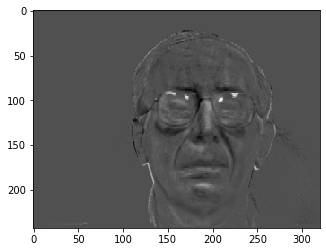

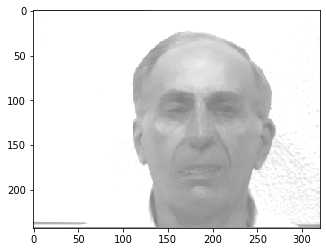

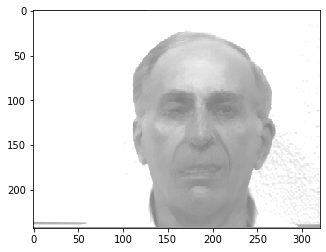

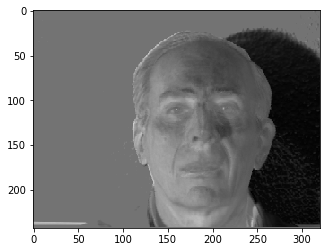

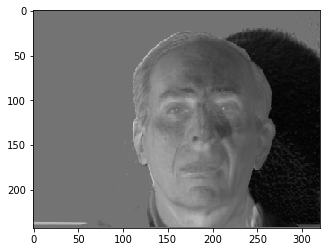

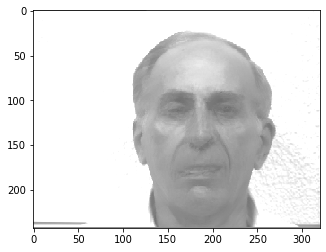

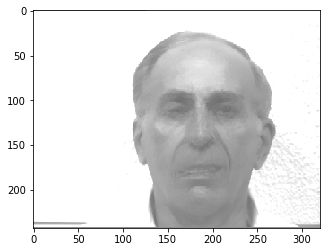

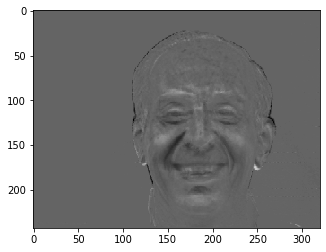

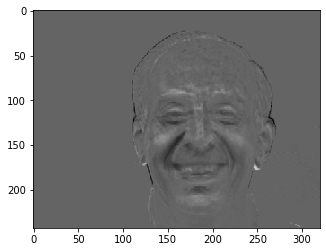

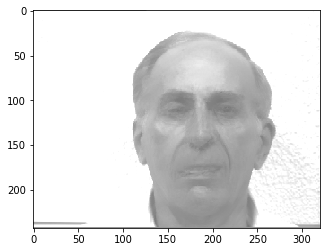

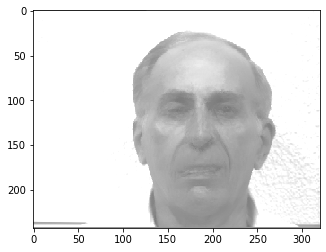

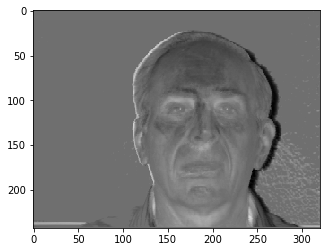

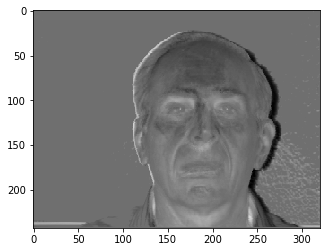

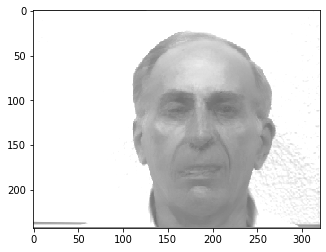

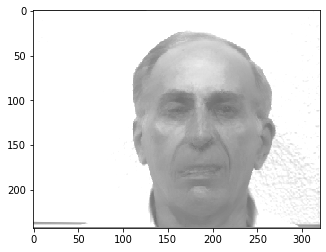

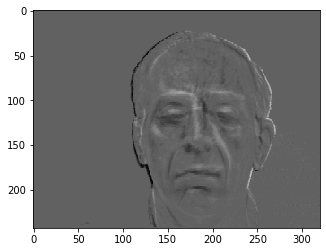

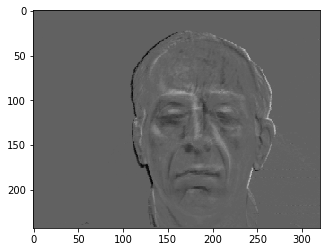

In [55]:
subject1_train_est = train_est[4]
subject1_out_hat = out_hat[4]
subject1_out_bftrain = out_bftrain[4]
subject1_out_accaltproj = out_accaltproj[4]

lowrank_train_est = subject1_train_est[0]
lowrank_out_hat = subject1_out_hat[0]
lowrank_out_bftrain = subject1_out_bftrain[0]
lowrank_out_accaltproj = subject1_out_accaltproj[0]

sparse_train_est = subject1_train_est[1]
sparse_out_hat = subject1_out_hat[1]
sparse_out_bftrain = subject1_out_bftrain[1]
sparse_out_accaltproj = subject1_out_accaltproj[1]
for i in range(11):
    plot_true_vs_est_matrices((lowrank_out_hat[:,i].reshape(320, 243).T) \
                            , (lowrank_out_accaltproj[:,i].reshape(320, 243).T) \
                            , (sparse_out_hat[:,i].reshape(320, 243).T) \
                            , (sparse_out_accaltproj[:,i].reshape(320, 243).T))

## on test data

In [59]:
print(list(net.parameters()))

[Parameter containing:
tensor(0.6978, requires_grad=True), Parameter containing:
tensor(0.0160, dtype=torch.float64, requires_grad=True)]


In [23]:
out_accaltproj_ontest = []
out_ircur_ontest = []
for i, M_true in enumerate(test):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    print(loss[-1])
    out_accaltproj_ontest.append((L0, S0, M_true))
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest.append((L0, S0, M_true))

tensor(8.9461e-07, dtype=torch.float64)
tensor(7.6016e-07, dtype=torch.float64)
tensor(7.8150e-07, dtype=torch.float64)
tensor(8.8878e-07, dtype=torch.float64)
tensor(8.0249e-07, dtype=torch.float64)
tensor(9.2261e-07, dtype=torch.float64)
tensor(8.7332e-07, dtype=torch.float64)
tensor(8.7300e-07, dtype=torch.float64)


In [25]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter, 243 * 320, 11), r, test)

7.62413511211029e-09
6.086725753596677e-09
9.165092786070923e-09
6.9466099373026285e-09
8.301112439670337e-09
8.599102552078634e-09
6.673772039627402e-09
6.374562910008193e-09
5.9405995314296205e-09
5.3511099244157955e-09
6.757160371185803e-09
5.379629755657052e-09
1.0288026184391397e-08
8.386786300609151e-09
9.123258568569795e-09
6.518995903498705e-09


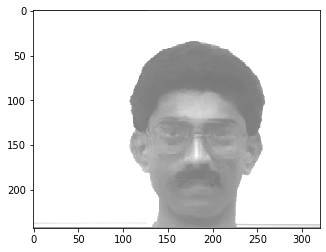

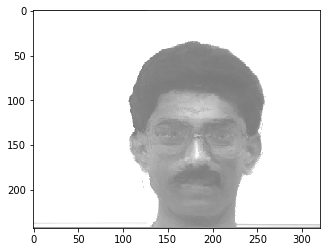

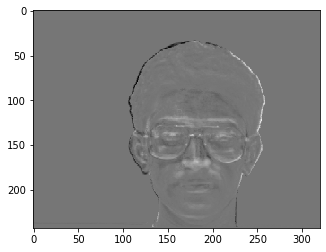

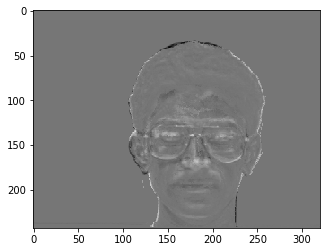

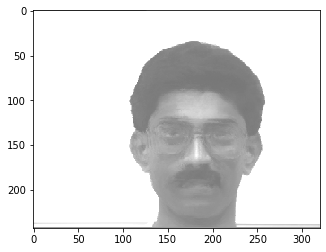

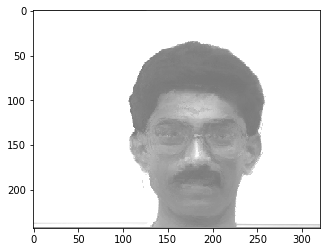

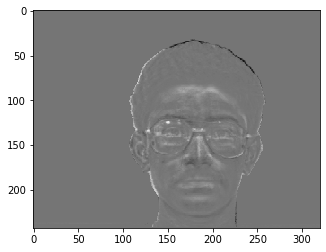

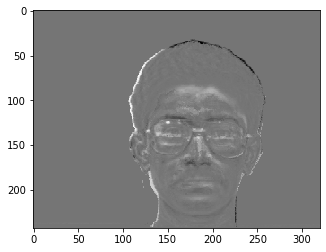

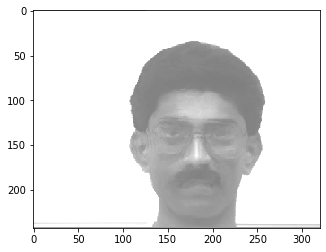

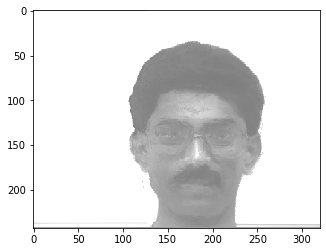

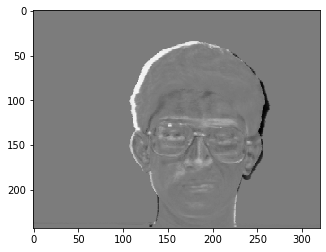

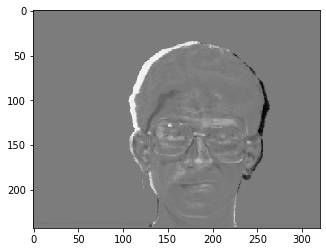

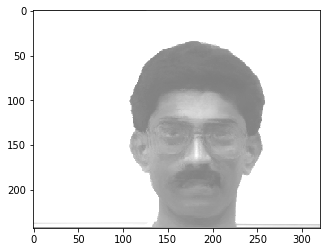

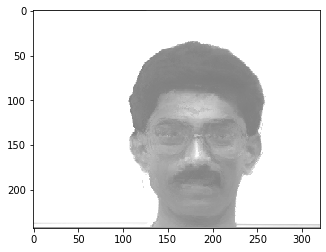

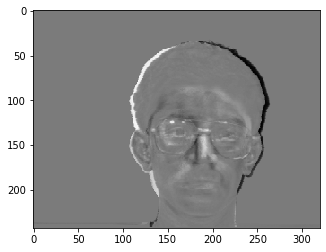

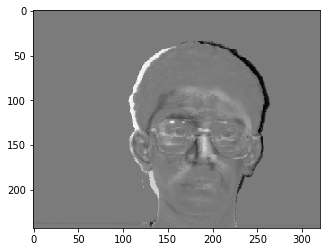

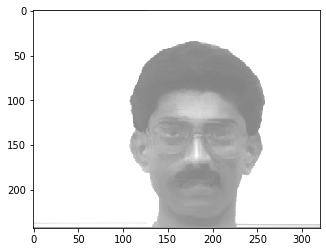

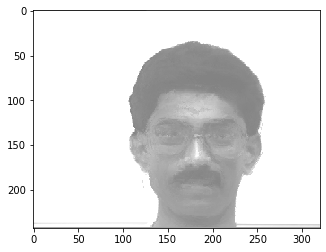

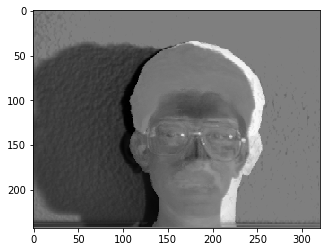

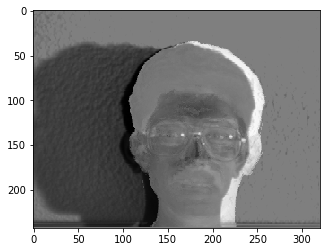

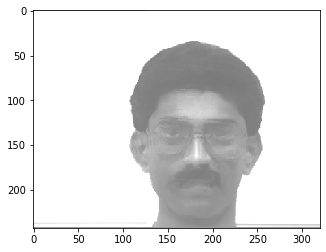

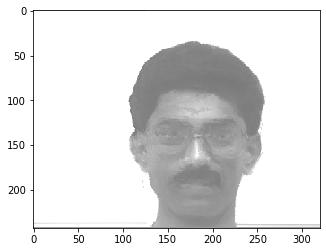

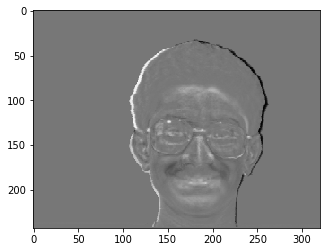

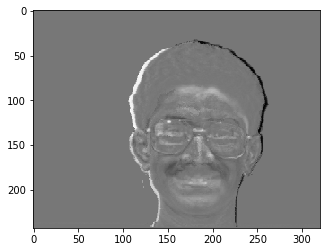

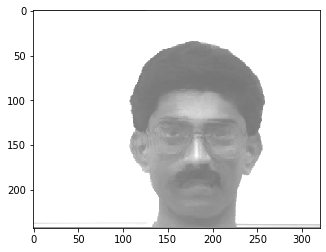

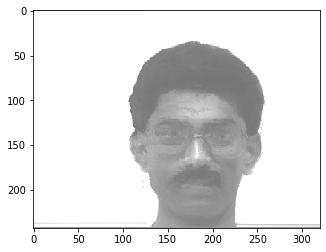

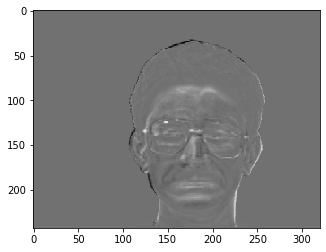

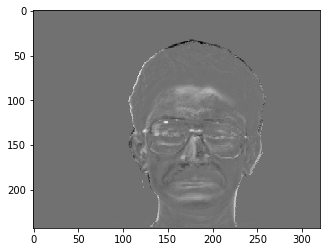

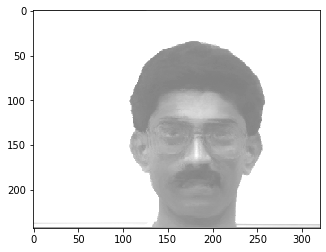

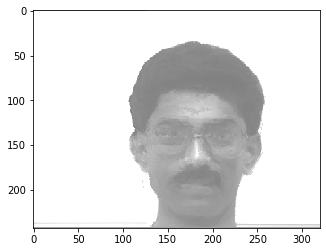

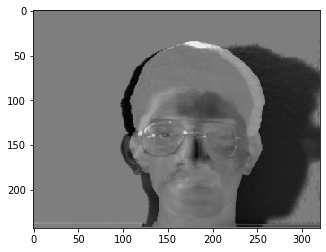

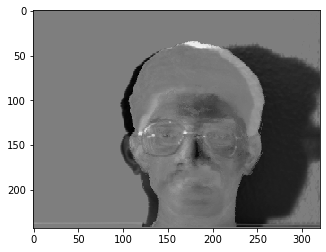

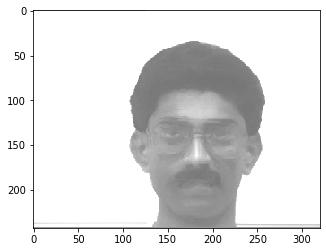

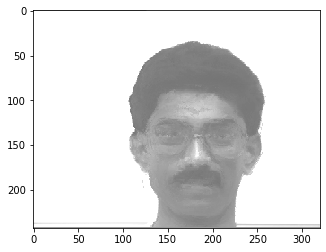

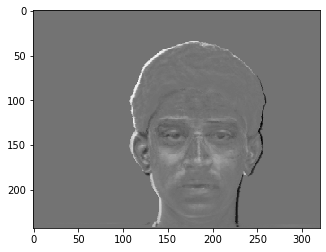

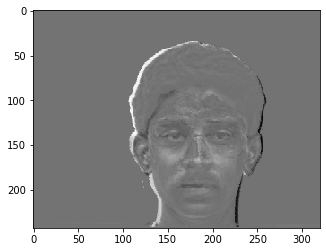

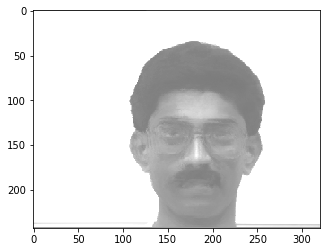

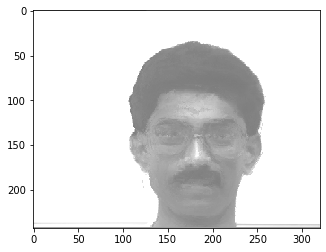

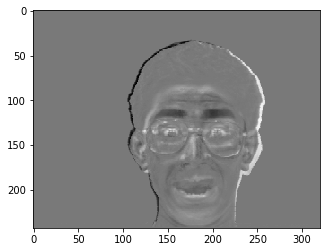

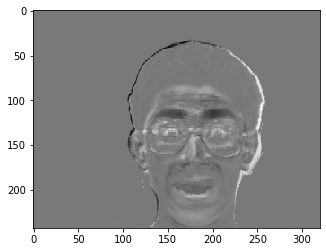

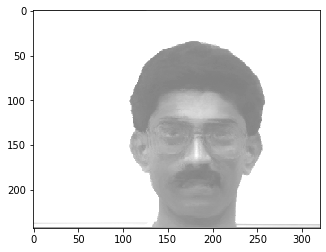

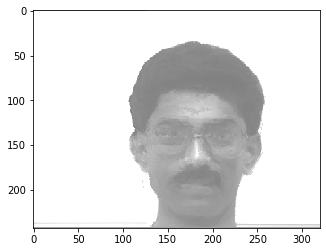

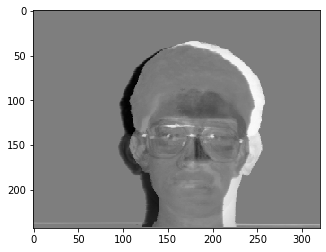

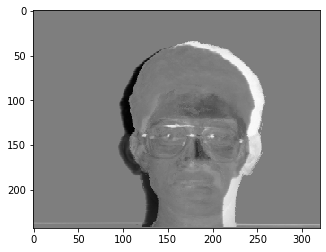

In [67]:
subject1_accaltproj_ontest = out_accaltproj_ontest[5]
subject1_ircur_ontest = out_ircur_ontest[5]
subject1_out_hat_ontest = out_hat_ontest[5]
subject1_out_bftrain_ontest = out_bftrain_ontest[5]
lowrank_accaltproj_ontest = subject1_accaltproj_ontest[0]
lowrank_ircur_ontest = subject1_ircur_ontest[0]
lowrank_out_hat_ontest = subject1_out_hat_ontest[0]
lowrank_out_bftrain_ontest = subject1_out_bftrain_ontest[0]
sparse_accaltproj_ontest = subject1_accaltproj_ontest[1]
sparse_ircur_ontest = subject1_ircur_ontest[1]
sparse_out_hat_ontest = subject1_out_hat_ontest[1]
sparse_out_bftrain_ontest = subject1_out_bftrain_ontest[1]
for i in range(11):
    plot_true_vs_est_matrices((lowrank_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
                            , (lowrank_ircur_ontest[:,i].reshape(320, 243).T * 255) \
                            , (sparse_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
                            , (sparse_ircur_ontest[:,i].reshape(320, 243).T * 255))

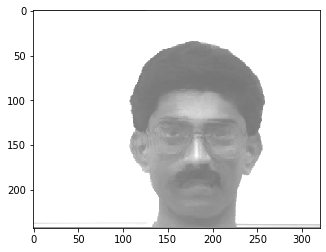

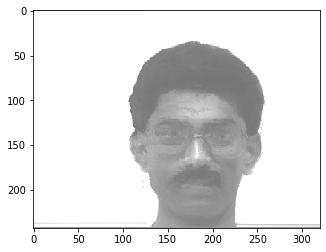

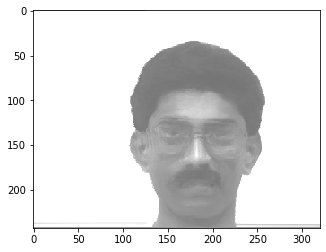

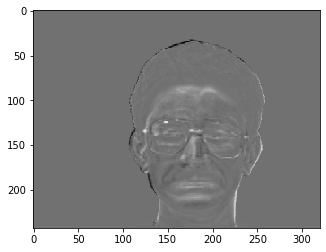

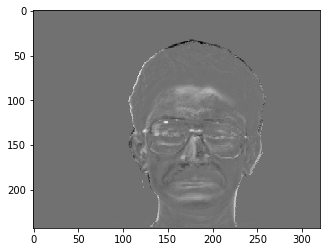

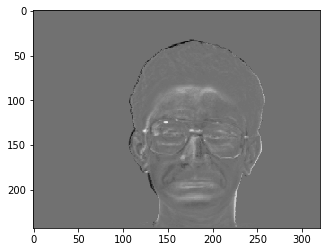

In [69]:
L_hat = (lowrank_out_hat_ontest[:,6].reshape(320, 243).T * 255)
S_hat = (sparse_out_hat_ontest[:,6].reshape(320, 243).T * 255)
L_ircur = (lowrank_ircur_ontest[:,6].reshape(320, 243).T * 255)
S_ircur = (sparse_ircur_ontest[:,6].reshape(320, 243).T * 255)
L_accaltproj = (lowrank_accaltproj_ontest[:,6].reshape(320, 243).T * 255)
S_accaltproj = (sparse_accaltproj_ontest[:,6].reshape(320, 243).T * 255)

combined = np.concatenate((L_hat, L_ircur, L_accaltproj, S_hat, S_ircur, S_accaltproj))
plt.imshow(L_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_unrolled_lr.eps', format='eps')
plt.show()
plt.imshow(L_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_ircur_lr.eps', format='eps')
plt.show()
plt.imshow(L_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_accaltproj_lr.eps', format='eps')
plt.show()
plt.imshow(S_hat, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_unrolled_sad.eps', format='eps')
plt.show()
plt.imshow(S_ircur, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_ircur_sad.eps', format='eps')
plt.show()
plt.imshow(S_accaltproj, vmin=np.min(combined), vmax = np.max(combined), cmap='gray')
plt.savefig('plots/face_accaltproj_sad.eps', format='eps')
plt.show()

# plot_true_vs_est_matrices((lowrank_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
#                         , (lowrank_ircur_ontest[:,i].reshape(320, 243).T * 255) \
#                         , (sparse_out_hat_ontest[:,i].reshape(320, 243).T * 255) \
#                         , (sparse_ircur_ontest[:,i].reshape(320, 243).T * 255))